Contents of data/: ['2']
Metadata loaded. Sample rows:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Image counts per found folder: {'HAM10000_images_part_1': 5000, 'HAM10000_images_part_2': 5015}
Class distribution: {'bkl': 1099, 'nv': 6705, 'df': 115, 'mel': 1113, 'vasc': 142, 'bcc': 514, 'akiec': 327}


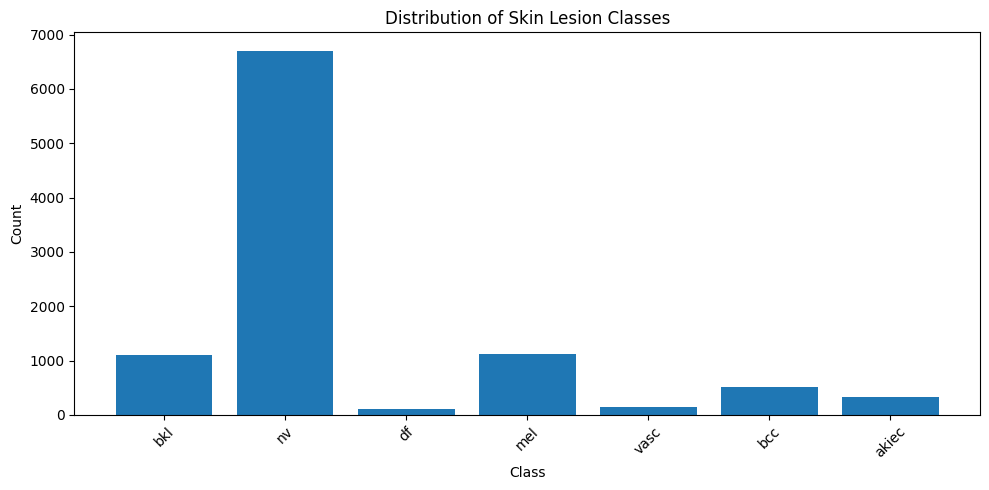

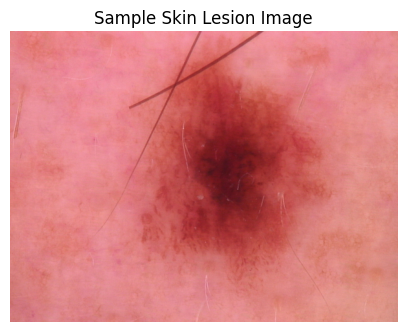

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from collections import Counter
from pathlib import Path

# Project root directory
project_root = "C:\\Users\\mcf\\PycharmProjects\\DeepLearnME"
data_dir = os.path.join(project_root, "data")

# Log the data directory structure for debugging
print("Contents of data/:", os.listdir(data_dir))

# Find metadata CSV dynamically
metadata_path = None
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file == "HAM10000_metadata.csv":
            metadata_path = os.path.join(root, file)
            break
    if metadata_path:
        break

# Load metadata
df = None
if metadata_path and os.path.exists(metadata_path):
    df = pd.read_csv(metadata_path)
    print("Metadata loaded. Sample rows:")
    print(df.head())
else:
    print("Metadata CSV not found. Check data/ structure or dataset contents.")

# Count images with flexible search
image_counts = {}
for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        # Look for folders with images (case-insensitive)
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(folder_path)):
            image_counts[dir_name] = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
print("Image counts per found folder:", image_counts)

# Class distribution from metadata
if df is not None and 'dx' in df.columns:  # Check if df is defined and has 'dx' column
    class_dist = Counter(df['dx'])
    print("Class distribution:", dict(class_dist))

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(class_dist.keys(), class_dist.values())
    plt.title("Distribution of Skin Lesion Classes")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(project_root, "class_distribution.png"))
    plt.show()
else:
    print("No class distribution plotted due to missing metadata or 'dx' column.")

# Visualize a sample image
sample_folder = next((f for f in image_counts.keys()), None)
if sample_folder:
    full_folder_path = next((os.path.join(root, sample_folder) for root, dirs, files in os.walk(data_dir) if sample_folder in dirs), None)
    if full_folder_path:
        sample_files = os.listdir(full_folder_path)
        if sample_files:
            sample_path = os.path.join(full_folder_path, sample_files[0])
            if os.path.exists(sample_path):
                img = cv2.imread(sample_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(5, 5))
                plt.imshow(img_rgb)
                plt.title("Sample Skin Lesion Image")
                plt.axis('off')
                plt.savefig(os.path.join(project_root, "sample_image.png"))
                plt.show()
            else:
                print(f"Sample image not found at {sample_path}. Verify image files.")
        else:
            print(f"No files found in {full_folder_path}.")
    else:
        print(f"Folder {sample_folder} not found in expected structure.")
else:
    print("No image folder found after search. Verify dataset structure in data/.")

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image

class SkinLesionDataset(Dataset):
    def __init__(self, csv_path, img_dirs, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dirs = img_dirs  # List of image directories
        self.transform = transform
        # Map string labels to numeric (assuming 'dx' column)
        self.label_map = {label: idx for idx, label in enumerate(self.df['dx'].unique())}
        self.df['dx_numeric'] = self.df['dx'].map(self.label_map)
        # Debug: Check a sample image path
        sample_img_id = self.df.iloc[0]['image_id']
        sample_path = self._find_image_path(sample_img_id)
        print(f"Testing sample path: {sample_path}, Exists: {os.path.exists(sample_path)}")

    def _find_image_path(self, img_id):
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, f"{img_id}.jpg")
            if os.path.exists(img_path):
                return img_path
            # Try other extensions
            for ext in ['.jpeg', '.png']:
                alt_path = os.path.join(img_dir, f"{img_id}{ext}")
                if os.path.exists(alt_path):
                    return alt_path
        raise FileNotFoundError(f"Image not found for ID {img_id} in any directory: {self.img_dirs}")

    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['image_id']
        img_path = self._find_image_path(img_id)
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx]['dx_numeric']
        if self.transform: image = self.transform(image)
        return image, label

# Project root directory
project_root = "C:\\Users\\mcf\\PycharmProjects\\DeepLearnME"
data_dir = os.path.join(project_root, "data")

# Log the data directory structure for debugging
print("Contents of data/:", os.listdir(data_dir))

# Find metadata CSV dynamically
metadata_path = None
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file == "HAM10000_metadata.csv":
            metadata_path = os.path.join(root, file)
            break
    if metadata_path:
        break

# Find all image directories dynamically
img_dirs = []
for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        if any(f.lower().endswith(('.jpg', '.jpeg', '.png')) for f in os.listdir(folder_path)):
            img_dirs.append(folder_path)
print("Found image directories:", img_dirs)

# Setup
if not metadata_path or not img_dirs:
    raise FileNotFoundError("Metadata CSV or image directories not found. Check data/ structure.")
print(f"Using metadata path: {metadata_path}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load dataset
dataset = SkinLesionDataset(metadata_path, img_dirs, transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_map))  # Dynamic number of classes
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train (simplified)
for epoch in range(5):  # Quick test
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
torch.save(model.state_dict(), os.path.join(project_root, "skin_lesion_model.pth"))

Contents of data/: ['2']
Found image directories: ['C:\\Users\\mcf\\PycharmProjects\\DeepLearnME\\data\\2\\HAM10000_images_part_1', 'C:\\Users\\mcf\\PycharmProjects\\DeepLearnME\\data\\2\\HAM10000_images_part_2']
Using metadata path: C:\Users\mcf\PycharmProjects\DeepLearnME\data\2\HAM10000_metadata.csv
Testing sample path: C:\Users\mcf\PycharmProjects\DeepLearnME\data\2\HAM10000_images_part_1\ISIC_0027419.jpg, Exists: True


C:\Users\mcf\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mcf\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 